In [1]:
from util.mesh import MeshProcessor
from tqdm import tqdm
import numpy as np
import dask
from dask.distributed import Client, progress
import pandas as pd
import socket
import os
from datetime import datetime

#cell = "jrc_hela-2"
cell = "jrc_mus-liver-zon-1"
organelle = "nucleus_ccMinMaxFilter120_480"
with Client(threads_per_worker=1, n_workers=1) as client:#, memory_limit='32GB')
    client.cluster.scale(10)
    dashboard_link = client.cluster.dashboard_link
    print(dashboard_link.replace("127.0.0.1",socket.gethostbyname_ex(socket.gethostname())[0]))

    mp = MeshProcessor(
        #path=f"https://janelia-cosem-datasets.s3.amazonaws.com/{cell}/neuroglancer/mesh/mito_seg",
        path=f"/nrs/cellmap/ackermand/meshes/multiresolution/jrc_mus-liver-zon-1/nucleus_ccMinMaxFilter120_480/multires",
        lod=5,
        min_branch_length=100,
        use_skeletons=False,
        numberrays=32
    )
    lazy_results = []
    for i in range(1, 2203+1, 1):  # range(1,87077,100): #
        # id 1208 is a weird messed up one
        lazy_results.append(mp.process_mesh(id=i))
    results = dask.compute(*lazy_results)

    df = pd.DataFrame.from_records(results)

    output_dir = f"output/mesh_info/{cell}/{organelle}/" + datetime.now().strftime("%Y%m%d_%H%M%S")
    os.makedirs(f"{output_dir}",exist_ok=True)
    df.to_csv(f"{output_dir}/mesh_info.csv",index=False)

/groups/scicompsoft/home/ackermand/miniconda3/envs/mesh_playground/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


http://ackermand-ws2.hhmi.org:8787/status


/groups/scicompsoft/home/ackermand/miniconda3/envs/mesh_playground/lib/python3.7/contextlib.py:119: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/groups/scicompsoft/home/ackermand/miniconda3/envs/mesh_playground/lib/python3.7/contextlib.py:119: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
malloc_consolidate(): unaligned fastbin chunk detected


In [6]:
from util.mesh import MeshProcessor

cell = "jrc_mus-liver-zon-1"
organelle = "nucleus_ccMinMaxFilter120_480"

mp = MeshProcessor(
    #path=f"https://janelia-cosem-datasets.s3.amazonaws.com/{cell}/neuroglancer/mesh/mito_seg",
    path=f"https://cellmap-vm1.int.janelia.org/nrs/ackermand/meshes/multiresolution/{cell}/{organelle}/multires",
    lod=5,
    min_branch_length=100,
    use_skeletons=False,
)
#mesh,ms = mp.get_mesh(773)
#_ = mesh.export("tmp.ply")
metrics = mp.process_mesh(1280).compute()
#ms.meshing_repair_non_manifold_edges()
#ms.compute_scalar_by_shape_diameter_function_per_vertex()
print(metrics)

/groups/scicompsoft/home/ackermand/miniconda3/envs/mesh_playground/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

(array([ 212.,  132.,  247.,  335.,  362.,  333.,  416., 1130., 3690.,
        1014.]),
 array([ 152.53587249,  891.83683351, 1631.13779454, 2370.43875556,
        3109.73971659, 3849.04067761, 4588.34163864, 5327.64259966,
        6066.94356068, 6806.24452171, 7545.54548273]),
 <BarContainer object of 10 artists>)

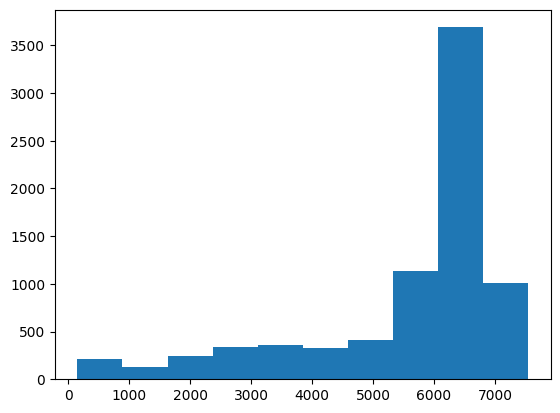

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(vsa)

In [1]:
from importlib import reload
import util.neuroglancer_predictor as NP
import util.fit_and_predict as FP
import pandas as pd
cell = "jrc_mus-liver-zon-1"
organelle = "nucleus_ccMinMaxFilter120_480"

df = pd.read_csv("/groups/scicompsoft/home/ackermand/Programming/mesh_playground/output/mesh_info/jrc_mus-liver-zon-1/nucleus_ccMinMaxFilter120_480/20231212_120612/mesh_info.csv")
reload(NP)
reload(FP)
np = NP.NeuroglancerPredictor("jrc_mus-liver-zon-1","nucleus_ccMinMaxFilter120_480",
                              class_info=[("hep. mono (h, red)", "h", "red"), 
                                        ("hep. bi (j, gray)", "j", "gray"), 
                                        ("epi. (k, blue)", "k", "blue"), 
                                        ("junk (l, magenta)", "l", "magenta")])
np.setup_neuroglancer()
fp = FP.FitAndPredict(df, np)
fp.set_metrics(list(df.columns[1:]))

## read in Aubrey's predictions

In [22]:
import numpy
output_df = pd.read_csv("/groups/scicompsoft/home/ackermand/Programming/mesh_playground/output/classification/jrc_mus-liver-zon-1/nucleus_ccMinMaxFilter120_480/20231212_134507/classification.csv")
hepatocyte_nuclei = []
for _,row in output_df.iterrows():
    if row["Class Name"] in ["hep. mono (h, red)","hep. bi (j, gray)"]:
        hepatocyte_nuclei.append(row["Object ID"])

print(','.join([str(n) for n in hepatocyte_nuclei]))

5,7,9,12,13,16,18,19,20,25,27,28,32,37,41,43,46,47,50,51,52,54,57,61,64,70,72,73,75,76,78,81,82,84,85,87,91,92,93,95,96,100,102,107,108,109,110,111,112,114,117,118,119,120,131,133,134,137,138,139,141,142,150,151,156,157,158,159,160,162,163,169,171,172,173,174,175,176,177,179,183,184,185,186,187,188,192,193,194,195,196,197,198,200,202,203,207,208,209,210,211,212,213,214,215,216,219,220,226,238,242,244,252,253,254,255,258,264,266,267,271,276,277,279,281,282,284,285,287,289,290,291,295,296,302,304,305,306,307,308,310,311,312,313,315,317,318,320,321,322,323,324,325,329,331,332,333,335,342,347,349,350,351,354,355,356,357,358,359,360,361,362,366,367,368,369,371,372,375,377,378,381,383,384,385,391,392,396,398,399,407,408,410,412,413,419,421,422,424,425,428,433,434,439,440,441,442,443,452,453,455,460,466,467,468,469,470,472,473,475,476,478,482,486,487,488,490,491,493,495,507,508,509,511,512,513,517,521,528,534,535,536,537,538,539,541,542,543,550,552,553,557,564,565,566,567,568,571,572,576,579,

In [21]:
class_description = []
for class_prediction in class_predictions:
    if class_prediction==0:
        class_description.append("hepatocyte (mononucleated)")
    elif class_prediction==1:
        class_description.append("hepatocyte (binucleated)")
    elif class_prediction==2:
        class_description.append("epithelial")
    elif class_prediction==3:
        class_description.append("junk")

classificaiton_df = pd.DataFrame({"Object ID": list(range(1,len(class_predictions)+1)),"Class Prediction": class_predictions, "Class Description": class_description})
classificaiton_df.to_csv(f"{cell}_{organelle}_classification.csv")

In [11]:
hepatocyte_ids = []
epithelial_ids = []
junk_ids = []
for idx, class_prediction in enumerate(class_predictions):
    if class_prediction<2:
        hepatocyte_ids.append(idx+1)
    elif class_prediction==2:
        epithelial_ids.append(idx+1)
    else:
        junk_ids.append(idx+1)

In [14]:
junk_ids

[1,
 2,
 3,
 6,
 8,
 10,
 11,
 14,
 15,
 17,
 21,
 22,
 25,
 26,
 30,
 35,
 36,
 40,
 44,
 48,
 65,
 79,
 90,
 103,
 105,
 119,
 121,
 122,
 123,
 125,
 126,
 127,
 128,
 129,
 130,
 136,
 143,
 144,
 145,
 146,
 147,
 152,
 164,
 165,
 166,
 167,
 178,
 180,
 181,
 189,
 190,
 205,
 222,
 223,
 224,
 227,
 228,
 229,
 230,
 231,
 233,
 234,
 236,
 245,
 246,
 247,
 259,
 261,
 272,
 273,
 286,
 297,
 298,
 299,
 301,
 303,
 314,
 319,
 327,
 339,
 341,
 344,
 345,
 346,
 352,
 363,
 364,
 365,
 370,
 379,
 380,
 386,
 387,
 388,
 389,
 401,
 402,
 405,
 414,
 415,
 416,
 417,
 427,
 429,
 431,
 436,
 437,
 445,
 446,
 447,
 449,
 451,
 459,
 461,
 462,
 463,
 464,
 485,
 489,
 496,
 498,
 499,
 500,
 502,
 503,
 510,
 514,
 516,
 518,
 520,
 527,
 529,
 530,
 531,
 532,
 533,
 544,
 545,
 547,
 549,
 554,
 555,
 561,
 573,
 574,
 575,
 578,
 583,
 584,
 585,
 586,
 588,
 593,
 595,
 605,
 611,
 612,
 613,
 614,
 616,
 621,
 622,
 623,
 628,
 634,
 636,
 637,
 638,
 639,
 642,
 643,
 6

In [4]:
list(df.columns[1:])

['id',
 'volume',
 'surface_area',
 'pic_0',
 'pic_normalized_0',
 'ob_0',
 'ob_normalized_0',
 'pic_1',
 'pic_normalized_1',
 'ob_1',
 'ob_normalized_1',
 'pic_2',
 'pic_normalized_2',
 'ob_2',
 'ob_normalized_2',
 'mean_curvature_mean',
 'mean_curvature_median',
 'mean_curvature_std',
 'gaussian_curvature_mean',
 'gaussian_curvature_median',
 'gaussian_curvature_std',
 'rms_curvature_mean',
 'rms_curvature_median',
 'rms_curvature_std',
 'abs_curvature_mean',
 'abs_curvature_median',
 'abs_curvature_std',
 'thickness_mean',
 'thickness_median',
 'thickness_std']

In [3]:
fp.set_metrics(
        [   "volume",
            "ob_normalized_0",
            "ob_normalized_1",
            "ob_normalized_2",
            "pic_normalized_0",
            "pic_normalized_1",
            "pic_normalized_2",
            "mean_curvature",
            "gaussian_curvature",
            "rms_curvature",
            "abs_curvature",
            "thickness",
            #"longest_path",
            #"num_fragments",
        ]   
)


Traceback (most recent call last):
  File "/groups/scicompsoft/home/ackermand/miniconda3/envs/mesh_playground/lib/python3.7/site-packages/neuroglancer/viewer_config_state.py", line 157, in invoke
    handler(state)
  File "/groups/scicompsoft/home/ackermand/Programming/mesh_playground/util/fit_and_predict.py", line 30, in fit_and_predict
    self.metrics = self.df[metric_names].to_numpy()
  File "/groups/scicompsoft/home/ackermand/miniconda3/envs/mesh_playground/lib/python3.7/site-packages/pandas/core/frame.py", line 3464, in __getitem__
    indexer = self.loc._get_listlike_indexer(key, axis=1)[1]
  File "/groups/scicompsoft/home/ackermand/miniconda3/envs/mesh_playground/lib/python3.7/site-packages/pandas/core/indexing.py", line 1314, in _get_listlike_indexer
    self._validate_read_indexer(keyarr, indexer, axis)
  File "/groups/scicompsoft/home/ackermand/miniconda3/envs/mesh_playground/lib/python3.7/site-packages/pandas/core/indexing.py", line 1377, in _validate_read_indexer
    raise

In [13]:
from sys import platform
if platform == "darwin":
    print("yo")

In [14]:
import pymeshlab
from xvfbwrapper import Xvfb

vdisplay = Xvfb()
vdisplay.start()

try:
    ms = pymeshlab.MeshSet()
    ms.load_new_mesh("tmp.ply")
    ms.compute_scalar_by_shape_diameter_function_per_vertex(numberrays=32)
except Exception as e:
    raise(e)
finally:
    vdisplay.stop()

Using OpenGL 3.1


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-ackermand'


In [11]:
list(df.columns[1:])

['volume',
 'surface_area',
 'pic_0',
 'pic_normalized_0',
 'ob_0',
 'ob_normalized_0',
 'pic_1',
 'pic_normalized_1',
 'ob_1',
 'ob_normalized_1',
 'pic_2',
 'pic_normalized_2',
 'ob_2',
 'ob_normalized_2',
 'mean_curvature_mean',
 'mean_curvature_median',
 'mean_curvature_std',
 'gaussian_curvature_mean',
 'gaussian_curvature_median',
 'gaussian_curvature_std',
 'rms_curvature_mean',
 'rms_curvature_median',
 'rms_curvature_std',
 'abs_curvature_mean',
 'abs_curvature_median',
 'abs_curvature_std',
 'thickness_mean',
 'thickness_median',
 'thickness_std']

In [9]:
from importlib import reload
import util
reload(util)
from util.mesh import MeshProcessor
from tqdm import tqdm
import numpy as np
import dask
from dask.distributed import Client, progress
import pandas as pd
import socket

mp = MeshProcessor(
    #path=f"https://janelia-cosem-datasets.s3.amazonaws.com/{cell}/neuroglancer/mesh/mito_seg",
    path=f"https://cellmap-vm1.int.janelia.org/nrs/ackermand/meshes/multiresolution/jrc_mus-liver-zon-1/nucleus_ccMinMaxFilter120_480/multires",
    lod=5,
    min_branch_length=100,
    use_skeletons=False,
    numberrays=32
)
mp.get_mesh(1389)


JSONDecodeError: Expecting value: line 1 column 1 (char 0)